In [2]:
# Import libraries
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import haversine as hs
import gurobipy as gp
from gurobipy import GRB
from shapely import wkt

# Helper modules
import helper_population_allocation as pa
import helper_distance_calculation as dc

# Avoid printing set copy warnings
import warnings
warnings.filterwarnings("ignore")

### Set up dataset and parameters

In [3]:
# Get the main buildings dataset 
buildings_df = gpd.read_file('../processed_data/relevant_buildings.shp')

# Create ID variable for each building
buildings_df.reset_index(drop=True, inplace=True)
buildings_df['building_id'] = buildings_df.index + 1
buildings_df['building_id'] = buildings_df.apply(lambda row: str(row['building_id']) + '-' + str(row['CLASS']) , axis=1)


In [4]:
# Get the geo IDs that can merge to USDA low income low access (from ACS data)
acs_data = pd.read_csv('ACSData.csv')
acs_data = acs_data[['geometry', 'geo_id', 'B01003_001E', 'B25010_001E']]
acs_data['geometry'] = acs_data['geometry'].apply(wkt.loads) # convert acs data to polygons
acs_data = gpd.GeoDataFrame(acs_data, geometry = 'geometry').set_crs(buildings_df.crs) # turn into polygons

# Do a spatial join from acs to buildings_df to get the propert geo_ids
buildings_df = buildings_df.sjoin(acs_data, how="left", predicate='intersects')
buildings_df['geo_id'] = buildings_df['geo_id'].str[-6:] # the last six characters is the tract ID'

# There are buildings that map onto multiple tracts based on the spatial join - don't know why this happens - see below
# buildings_df[buildings_df.duplicated(subset=['building_id'], keep=False)].sort_values('building_id')

# So we drop duplicates
buildings_df = buildings_df.drop_duplicates(subset=['building_id'], keep='first')


In [5]:
# Import usda low income low access data
usda_lila = pd.read_csv('../input_data/usda_lowincomelowaccess.csv')

usda_lila = usda_lila[['Allegheny_Tracts_GEOID','USDA_Data_LILATracts_1And10','USDA_Data_LILATracts_halfAnd10']]

# Get the right geo_id to merge
usda_lila['geo_id'] = usda_lila['Allegheny_Tracts_GEOID'].astype(str)


usda_lila['geo_id'] = usda_lila['geo_id'].str[-6:]

usda_lila

# Merge these definitions onto buildings_df
buildings_df = buildings_df.merge(usda_lila, how='left', on='geo_id')

# Drop building_id duplicates
buildings_df = buildings_df.drop_duplicates('building_id')

# If the buildings didn't merge, for now just assume LILA variables are 1
buildings_df[['USDA_Data_LILATracts_1And10','USDA_Data_LILATracts_halfAnd10']].fillna(1,inplace=True)

In [6]:
# How many tracts are LILA
tractlevel_access = buildings_df.groupby('geo_id').aggregate(lila_1_10 = ('USDA_Data_LILATracts_1And10', max))
tractlevel_access['lila_1_10'].value_counts()


0.0    125
1.0     10
Name: lila_1_10, dtype: int64

In [7]:
# # Filter out if not LILA at 1 mile
buildings_df = buildings_df[buildings_df['USDA_Data_LILATracts_1And10'] == 1]

# Picking which tracts
#buildings_df[buildings_df['hood'].str.contains('Crafton Heights')]
#buildings_df['hood'].drop_duplicates()

# Keep only 3 census tract: hazelwood, homewood north, belmar, crafton heights
#buildings_df = buildings_df[buildings_df['geo_id'].isin(['562300','523100','561900','562600','562800','290400','120300'])]


In [8]:
# Create arrays to track ordering (residential)
res_buildings = buildings_df[buildings_df['class_reco'].str.contains('Residential')]
res_buildings = res_buildings.sort_values('building_id')
res_buildings = dc.get_geocoordinate(res_buildings, 'geometry')

res_buildings_array = np.array(res_buildings['building_id'])
res_buildings_coordinates_array = np.array(res_buildings['coordinates'])

# Create arrays to track ordering (Commercial)
comm_buildings = buildings_df[buildings_df['class_reco'].str.contains('commercial')]
comm_buildings = comm_buildings.sort_values('building_id')
comm_buildings = dc.get_geocoordinate(comm_buildings, 'geometry')

comm_buildings_array = np.array(comm_buildings['building_id'])
comm_buildings_coordinates_array = np.array(comm_buildings['coordinates'])

# # Create arrays to track ordering (grocery stores) - choosing one LILA tract, so no grocery stores
# grocery_stores = buildings_df[buildings_df['class_reco'].str.contains('Grocery')]
# grocery_stores = grocery_stores.sort_values('building_id')
# grocery_stores = dc.get_geocoordinate(grocery_stores, 'geometry')

# grocery_stores_array = np.array(grocery_stores['building_id'])
# grocery_stores_coordinates_array = np.array(grocery_stores['coordinates'])

In [9]:
print(f'There are now {len(comm_buildings_array)} commercial buildings')
print(f'There are now {len(res_buildings)} residential buildings')

There are now 560 commercial buildings
There are now 10306 residential buildings


In [10]:
# Import res comm access matrix again
#res_comm_distance_matrix = np.load('res_comm_distance_matrix.npy')

# Need to recalculate distance and access matrices based on new dataset (filtered)
res_comm_distance_matrix, res_comm_access_matrix = dc.calculate_access(res_buildings_coordinates_array, comm_buildings_coordinates_array)

# Creating a modified res comm access matrix 
res_comm_access_matrix = res_comm_distance_matrix.copy()
res_comm_access_matrix[res_comm_access_matrix <= 0.5] = 1
res_comm_access_matrix[res_comm_access_matrix != 1] = 0

# Create a modified res existing access array
# res_groc_distance_matrix, res_groc_access_matrix = dc.calculate_access(res_buildings_coordinates_array, grocery_stores_coordinates_array)

# res_groc_access_matrix = res_groc_distance_matrix.copy()
# res_groc_access_matrix[res_groc_access_matrix <= 0.5] = 1
# res_groc_access_matrix[res_groc_access_matrix != 1] = 0

# res_access_array = np.amax(res_groc_access_matrix, 1)

# Assume that none of the residential buildings have access 
res_access_array = np.zeros(len(res_buildings_array))

In [11]:
# Create parameter matrices (Res Population - Pj)
# ith value indicates the population in the ith column

# generate population numbers
res_buildings['population'] = 0 # baseline is nobody lives in a building
res_buildings.loc[res_buildings['class_reco'] == '1-Unit Residential', 'population'] = 1
res_buildings.loc[res_buildings['class_reco'] == '2-Unit Residential', 'population'] = 2
res_buildings.loc[res_buildings['class_reco'] == '3-Unit Residential', 'population'] = 3
res_buildings.loc[res_buildings['class_reco'] == '4+ Unit Residential', 'population'] = 4
# multiply by average household size
res_buildings['population'] = res_buildings['population']*res_buildings['B25010_001E'] 

res_population_array = np.array(res_buildings['population'])
res_population_array

array([1.94, 1.94, 1.94, ..., 3.68, 3.68, 3.68])

In [12]:
# Create demand matrix - number of unsatisfied customers
res_demand = res_population_array
res_demand[np.where(res_access_array == 1)] = 0 # setting effective demand to zero for buildings that have existing access to a grocery store

### Optimization - with one store placement

In [100]:
### Testing modeling stuff

# Parameters
num_commercial_buildings = res_comm_distance_matrix.shape[1]
num_residential_buildings = len(res_demand)
num_stores = 1

# Implement model
m = gp.Model('Facility location')

# Decision variables 
select_one = m.addVars(range(num_commercial_buildings), vtype=GRB.BINARY, name='select') # select location
assign = m.addVars(range(num_residential_buildings), range(num_commercial_buildings), vtype=GRB.BINARY, name='assign') # assignment of residential building to cluster

# Objective function - min total distance from residential buildings to their assigned grocery store, multiplied by demand
m.setObjective(sum(sum(res_demand[i] * res_comm_distance_matrix[i,j] * assign[i, j] for i in range(num_residential_buildings)) for j in range(num_commercial_buildings)))
m.modelSense = GRB.MINIMIZE

# Constraints
m.addConstr(sum(select_one[i] for i in range(len(select_one))) <= num_stores, name='store_limit')

#m.addConstr(select.sum() <= num_stores, name = 'store_limit') # Facility limit
for i in range(num_residential_buildings):
    m.addConstr(sum(assign[i,j] for j in range(num_commercial_buildings)) ==  1) # can only assign each residential building to one store

for i in range(num_residential_buildings):
    for j in range(num_commercial_buildings):
        m.addConstr(assign[i,j] <= select_one[j], name='open2assign') # locations can only be assigned demand if they are selected

# Optimize  
m.optimize()


Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5781667 rows, 5771920 columns and 17314640 nonzeros
Model fingerprint: 0x23dafd21
Variable types: 0 continuous, 5771920 integer (5771920 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-03, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 0 rows and 0 columns (presolve time = 5s) ...
Presolve removed 0 rows and 0 columns (presolve time = 53s) ...
Presolve removed 0 rows and 0 columns (presolve time = 55s) ...
Presolve removed 0 rows and 0 columns (presolve time = 61s) ...
Presolve removed 0 rows and 0 columns (presolve time = 65s) ...
Presolve removed 0 rows and 0 columns (presolve time = 70s) ...
Presolve removed 0 rows and 0 columns (presolve time = 75s) ...


KeyboardInterrupt: 

Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "c:\Users\mihir\anaconda3\lib\site-packages\ipykernel\iostream.py", line 386, in write
    def write(self, string):
KeyboardInterrupt: 


Presolve removed 0 rows and 4318214 columns (presolve time = 1594s) ...
Presolve removed 4318214 rows and 4318214 columns (presolve time = 1596s) ...
Presolve removed 4318214 rows and 4318631 columns (presolve time = 1608s) ...
Presolve removed 4318214 rows and 4318632 columns (presolve time = 1610s) ...
Presolve removed 4318214 rows and 4318632 columns (presolve time = 1615s) ...
Presolve removed 4318214 rows and 4318632 columns
Presolve time: 1616.42s
Presolved: 1463453 rows, 1453288 columns, 4369886 nonzeros
Variable types: 0 continuous, 1453288 integer (1453288 binary)
Found heuristic solution: objective 183029.54497
Found heuristic solution: objective 118697.32880

Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 0.52s

Barrier statistics:
 Dense cols : 142
 AA' NZ     : 2.917e+06
 Factor NZ  : 5.962e+06 (roughly 1.2 GB of memory)
 Factor Ops : 2.605e+08 (less than 1 second per iterati

### Results Analysis: one store placement

In [108]:
# Which stores were chosen?
chosen_store_indices_one = []
chosen_building_ids_one = []

for i in range(len(select_one)):
    if select_one[i].x == 1:
        chosen_store_indices_one.append(i)

for i in chosen_store_indices_one:
    chosen_building_ids_one.append(comm_buildings_array[i])

# Total new people given access to (remember, we assume that nobody already has access in these low income low access tracts)
new_access_tot_one = []
for i in chosen_store_indices_one:
    x = res_comm_access_matrix[:,i] # residential buildings access matrix with the specific chosen store
    tot_new = np.dot(res_population_array, x)
    new_access_tot_one.append(tot_new)

print(chosen_store_indices_one, chosen_building_ids_one, new_access_tot_one)

[554] ['96061-C'] [1900.7199999999898]


<AxesSubplot:>

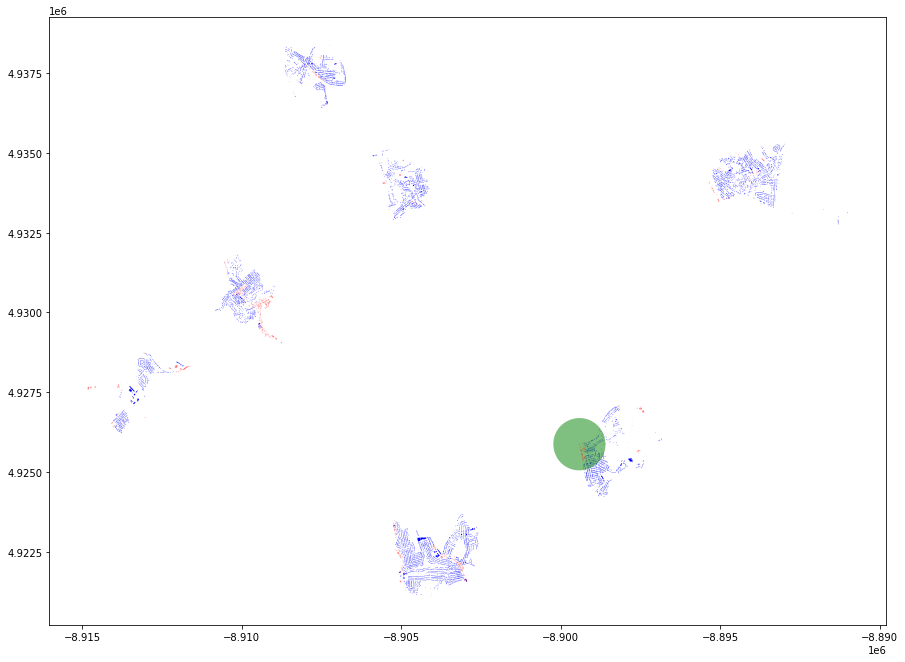

In [102]:
## Plotting results

# Read results
chosen_buildings = buildings_df[buildings_df.building_id.isin(chosen_building_ids_one)]


# grocery_stores = buildings_df[buildings_df['class_reco'].str.contains('Grocery')]
# grocery_stores['geometry'] = grocery_stores['geometry'].to_crs(epsg=3857) # converting to this CRS changes the units to meters
# grocery_stores['geometry'] = grocery_stores['geometry'].buffer(804.67) # 1609 meters = 1 mile - buffering adds a buffer around the point with this radius

res_buildings = buildings_df[buildings_df['class_reco'].str.contains('Residential')]
res_buildings['geometry'] = res_buildings['geometry'].to_crs(epsg=3857)

comm_buildings = buildings_df[buildings_df['class_reco'].str.contains('commercial')]
comm_buildings['geometry'] = comm_buildings['geometry'].to_crs(epsg=3857)

chosen_buildings['geometry'] = chosen_buildings['geometry'].to_crs(epsg=3857)
chosen_buildings['geometry'] = chosen_buildings['geometry'].buffer(804.67)


# plotting
f, ax = plt.subplots(figsize=(15,15))
res_buildings.plot(ax=ax, color='blue', label='Residential buildings')
chosen_buildings.plot(ax=ax, alpha=0.5, color='green', label='New stores placement')
comm_buildings.plot(ax=ax, alpha=0.5, color='red', label='Commercial buildings')

## Three store placement

In [97]:
### Testing modeling stuff

# Parameters
num_commercial_buildings = res_comm_distance_matrix.shape[1]
num_residential_buildings = len(res_demand)
num_stores = 3

# Implement model
m = gp.Model('Facility location')

# Decision variables 
select = m.addVars(range(num_commercial_buildings), vtype=GRB.BINARY, name='select') # select location
assign = m.addVars(range(num_residential_buildings), range(num_commercial_buildings), vtype=GRB.BINARY, name='assign') # assignment of residential building to cluster

# Objective function - min total distance from residential buildings to their assigned grocery store, multiplied by demand
m.setObjective(sum(sum(res_demand[i] * res_comm_distance_matrix[i,j] * assign[i, j] for i in range(num_residential_buildings)) for j in range(num_commercial_buildings)))
m.modelSense = GRB.MINIMIZE

# Constraints
m.addConstr(sum(select[i] for i in range(len(select))) <= num_stores, name='store_limit')

#m.addConstr(select.sum() <= num_stores, name = 'store_limit') # Facility limit
for i in range(num_residential_buildings):
    m.addConstr(sum(assign[i,j] for j in range(num_commercial_buildings)) ==  1) # can only assign each residential building to one store

for i in range(num_residential_buildings):
    for j in range(num_commercial_buildings):
        m.addConstr(assign[i,j] <= select[j], name='open2assign') # locations can only be assigned demand if they are selected

# Optimize
m.optimize()


Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5781667 rows, 5771920 columns and 17314640 nonzeros
Model fingerprint: 0x81e997d6
Variable types: 0 continuous, 5771920 integer (5771920 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-03, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 0 rows and 0 columns (presolve time = 5s) ...
Presolve removed 0 rows and 0 columns (presolve time = 58s) ...
Presolve removed 0 rows and 0 columns (presolve time = 61s) ...
Presolve removed 0 rows and 0 columns (presolve time = 65s) ...
Presolve removed 0 rows and 0 columns (presolve time = 70s) ...
Presolve removed 0 rows and 0 columns (presolve time = 75s) ...
Presolve removed 0 rows and 0 columns (presolve time = 80s) ...
Presolve removed 0 rows and 0 columns (presolve time = 86s) ...
Presolve removed 0 rows and 0 c

In [98]:
# Which stores were chosen?
chosen_store_indices = []
chosen_building_ids = []

for i in range(len(select)):
    if select[i].x == 1:
        chosen_store_indices.append(i)

for i in chosen_store_indices:
    chosen_building_ids.append(comm_buildings_array[i])

# Total new people given access to (remember, we assume that nobody already has access in these low income low access tracts)
new_access_tot = []
for i in chosen_store_indices:
    x = res_comm_access_matrix[:,i] # residential buildings access matrix with the specific chosen store
    tot_new = np.dot(res_population_array, x)
    new_access_tot.append(tot_new)

print(chosen_store_indices, chosen_building_ids, new_access_tot)

[185, 212, 432] ['48973-R', '6363-R', '83555-R'] [10894.600000000002, 5054.990000000014, 2700.7200000000116]


In [125]:
sum(new_access_tot)

18650.310000000027

<AxesSubplot:>

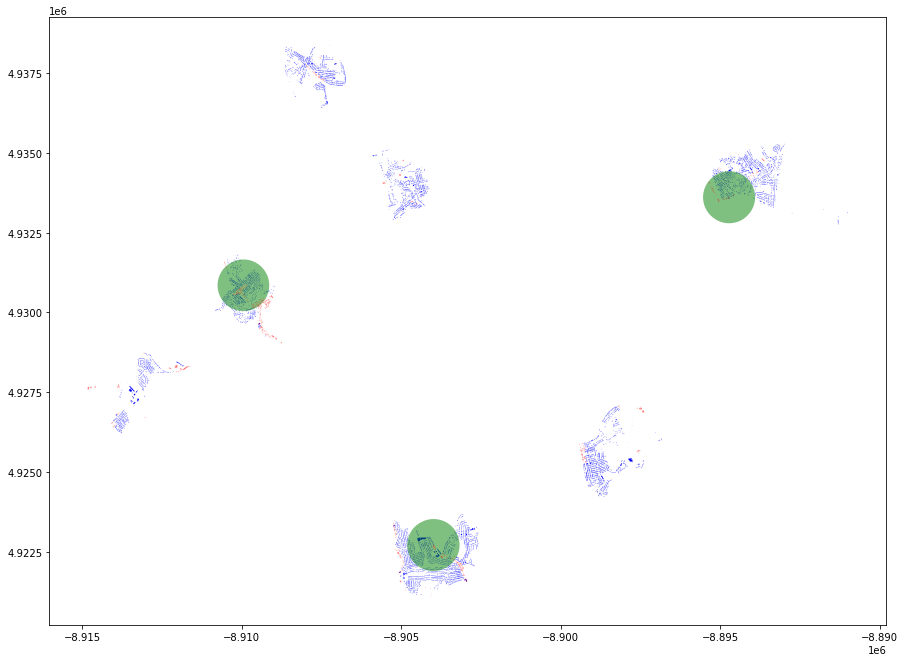

In [99]:
## Plotting results

# Read results
chosen_buildings = buildings_df[buildings_df.building_id.isin(chosen_building_ids)]


# grocery_stores = buildings_df[buildings_df['class_reco'].str.contains('Grocery')]
# grocery_stores['geometry'] = grocery_stores['geometry'].to_crs(epsg=3857) # converting to this CRS changes the units to meters
# grocery_stores['geometry'] = grocery_stores['geometry'].buffer(804.67) # 1609 meters = 1 mile - buffering adds a buffer around the point with this radius

res_buildings = buildings_df[buildings_df['class_reco'].str.contains('Residential')]
res_buildings['geometry'] = res_buildings['geometry'].to_crs(epsg=3857)

comm_buildings = buildings_df[buildings_df['class_reco'].str.contains('commercial')]
comm_buildings['geometry'] = comm_buildings['geometry'].to_crs(epsg=3857)

chosen_buildings['geometry'] = chosen_buildings['geometry'].to_crs(epsg=3857)
chosen_buildings['geometry'] = chosen_buildings['geometry'].buffer(804.67)


# plotting
f, ax = plt.subplots(figsize=(15,15))
res_buildings.plot(ax=ax, color='blue', label='Residential buildings')
chosen_buildings.plot(ax=ax, alpha=0.5, color='green', label='New stores placement')
comm_buildings.plot(ax=ax, alpha=0.5, color='red', label='Commercial buildings')

### Getting Model 1 results on LILA subset to compare

In [13]:
### Running Model 1 on LILA subset

def place_n_stores(num_stores, access_matrix, access_array):

    store_indices = []
    store_ids = []
    marginal_access_gain = []

    res_access_array_copy = access_array.copy()
    for n in range(num_stores):

        if np.sum(res_access_array_copy) == len(res_buildings_array): # This means every building now has access
            pass
        else:
            # STEP 1
            existing_access_indices = res_access_array_copy.nonzero()[0] # These are indices of residential buildings that currently have access
            res_comm_access_matrix_subset = np.delete(access_matrix, existing_access_indices, axis=0 )

            # STEP 2
            res_population_array_sub = np.delete(res_population_array, existing_access_indices, axis=0)

            # STEP 3
            res_population_array_sub = np.reshape(res_population_array_sub, (-1, len(res_population_array_sub)))
            new_access_array = np.matmul(res_population_array_sub, res_comm_access_matrix_subset)

            chosen_comm_index = np.argmax(new_access_array)
            chosen_comm_building = comm_buildings_array[chosen_comm_index]
            new_access_created = np.max(new_access_array)

            # STEP 4: Update results and arrays
            
            # Which residential buildings does this new store give access to
            new_buildings_with_access = access_matrix[:,chosen_comm_index].nonzero()[0]    # These are the indices in the res_access_array that need to be replaced (these buildings now have access)

            # Update the access values of these buildings in the access array
            replace_vals = list(np.ones(new_buildings_with_access.shape)) # These are the values which with certain elements of the access array will be replaced with

            # Perform replace
            res_access_array_copy[new_buildings_with_access] = replace_vals

            # STEP 5: Store results
            store_indices.append(chosen_comm_index)
            store_ids.append(chosen_comm_building)
            marginal_access_gain.append(new_access_created)



    return store_indices, store_ids, marginal_access_gain




In [14]:
m1_indices, m1_ids, m1_new_access = place_n_stores(3, access_array=res_access_array, access_matrix=res_comm_access_matrix)


In [126]:
sum(m1_new_access)

19570.840000000044

No handles with labels found to put in legend.


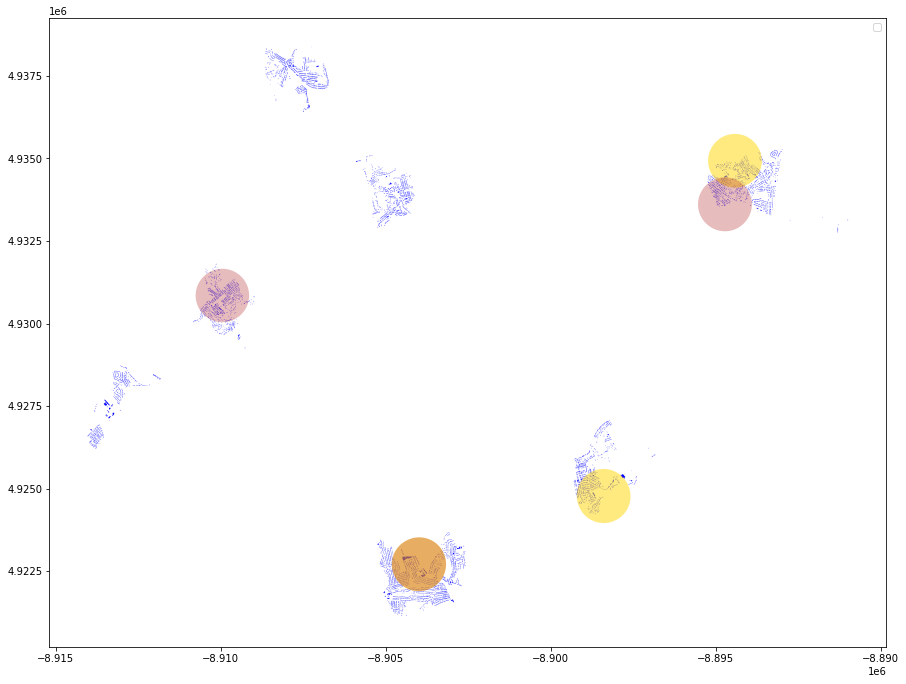

Chosen M1 hoods: 6362                      Carrick
48913    Lincoln-Lemington-Belmar
95660                   Hazelwood
Name: hood, dtype: object
Chosen M2 hoods: 6362                      Carrick
48972    Lincoln-Lemington-Belmar
83554                     Elliott
Name: hood, dtype: object


In [16]:
## Plotting results

m2_ids = ['48973-R', '6363-R', '83555-R']
m1_ids

# Read results
chosen_buildings_m1 = buildings_df[buildings_df.building_id.isin(m1_ids)]
chosen_buildings_m2 = buildings_df[buildings_df.building_id.isin(m2_ids)]

res_buildings = buildings_df[buildings_df['class_reco'].str.contains('Residential')]
res_buildings['geometry'] = res_buildings['geometry'].to_crs(epsg=3857)

comm_buildings = buildings_df[buildings_df['class_reco'].str.contains('commercial')]
comm_buildings['geometry'] = comm_buildings['geometry'].to_crs(epsg=3857)

chosen_buildings_m2['geometry'] = chosen_buildings_m2['geometry'].to_crs(epsg=3857)
chosen_buildings_m2['geometry'] = chosen_buildings_m2['geometry'].buffer(804.67)

chosen_buildings_m1['geometry'] = chosen_buildings_m1['geometry'].to_crs(epsg=3857)
chosen_buildings_m1['geometry'] = chosen_buildings_m1['geometry'].buffer(804.67)


# plotting
f, ax = plt.subplots(figsize=(15,15))
res_buildings.plot(ax=ax, color='blue', label='Residential buildings')
chosen_buildings_m1.plot(ax=ax, alpha=0.5, color='gold', label='New stores M1')
chosen_buildings_m2.plot(ax=ax, alpha=0.3, color='firebrick', label='New stores M2')
ax.legend(loc="upper right")
plt.show()

print(f"Chosen M1 hoods: {chosen_buildings_m1.hood.drop_duplicates()}")
print(f"Chosen M2 hoods: {chosen_buildings_m2.hood.drop_duplicates()}")
